In [39]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import imageio

# Dataset generation
def get_dataset():
    np.random.seed(45)
    num_samples = 40
    x1 = np.random.uniform(-1, 1, num_samples)
    f_x = 3 * x1 + 4
    eps = np.random.randn(num_samples)
    y = f_x + eps

    x_train = torch.tensor(x1, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    return x_train, y_train


In [40]:
x_train, y_train = get_dataset()
x_train.shape, y_train.shape

(torch.Size([40, 1]), torch.Size([40, 1]))

In [41]:

# Linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.theta_0 = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.theta_1 = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor):
        return self.theta_1 * x + self.theta_0

# Loss function
def mse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


In [42]:
def create_gif(folder_name, gif_name):
    images = []
    try:
        for filename in sorted(os.listdir(folder_name)):
            if filename.endswith(".png") and filename.startswith("epoch_"):
                file_path = os.path.join(folder_name, filename)
                images.append(imageio.imread(file_path))
        
        if images:
            imageio.mimsave(gif_name, images, duration=0.5)
            print(f"GIF created: {gif_name}")
        else:
            print(f"No images found in {folder_name} to create GIF.")
    except Exception as e:
        print(f"Error creating GIF {gif_name}: {str(e)}")


In [43]:
def save_contour_plot(x_train, y_train, theta_0_history, theta_1_history, model, method_name, epoch, folder_name, final=False):
    theta_0_range = np.linspace(-5, 5, 100)
    theta_1_range = np.linspace(-5, 5, 100)
    theta_0_mesh, theta_1_mesh = np.meshgrid(theta_0_range, theta_1_range)

    # Create contour plot for loss function
    loss_values = np.zeros_like(theta_0_mesh)
    for i in range(theta_0_mesh.shape[0]):
        for j in range(theta_0_mesh.shape[1]):
            y_pred = theta_1_mesh[i, j] * x_train.numpy() + theta_0_mesh[i, j]
            loss_values[i, j] = np.mean((y_pred - y_train.numpy()) ** 2)

    plt.figure(figsize=(10, 8))
    plt.contourf(theta_0_mesh, theta_1_mesh, loss_values, levels=50, cmap="viridis")
    plt.colorbar(label="Loss")

    # Plot optimization path
    plt.plot(theta_0_history, theta_1_history, marker='o', color='r', label=method_name)
    plt.xlabel('theta_0')
    plt.ylabel('theta_1')
    plt.legend()
    plt.title(f"{method_name} - Epoch {epoch+1}")
    plt.tight_layout()  
    plt.savefig(f"{folder_name}/epoch_{epoch+1:04d}.png", dpi=100)  
    plt.close()

    if final:
        plt.figure(figsize=(10, 8))
        plt.contourf(theta_0_mesh, theta_1_mesh, loss_values, levels=50, cmap="viridis")
        plt.colorbar(label="Loss")
        plt.plot(theta_0_history, theta_1_history, marker='o', color='r', label=method_name)
        plt.xlabel('theta_0')
        plt.ylabel('theta_1')
        plt.legend()
        plt.title(f"{method_name} - Final Contour Plot")
        plt.tight_layout()
        plt.savefig(f"{folder_name}/final_contour.png", dpi=100)
        plt.close()

In [44]:

# Gradient descent with plotting
def gradient_descent(model, x_train, y_train, method_name, folder_name, batch_size=None, lr=0.01, max_epochs=1000, epsilon=0.001):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    theta_0_history, theta_1_history = [], []

    os.makedirs(folder_name, exist_ok=True)  # Create folder for saving plots

    for epoch in range(max_epochs):
        epoch_loss = 0
        indices = torch.randperm(len(x_train)) if batch_size else torch.arange(len(x_train))

        for i in range(0, len(x_train), batch_size or len(x_train)):
            batch_indices = indices[i:i+batch_size] if batch_size else indices
            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = mse_loss(y_batch, y_pred)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = epoch_loss / len(x_train)
        losses.append(avg_loss)

        # Save parameter history for contour plot
        theta_0_history.append(model.theta_0.item())
        theta_1_history.append(model.theta_1.item())

        # Save contour plot for every 100 epochs
        if (epoch + 1) % 100 == 0:
            save_contour_plot(x_train, y_train, theta_0_history, theta_1_history, model, method_name, epoch, folder_name)

        if avg_loss < epsilon:
            print(f"{method_name} converged after {epoch+1} epochs")
            break
        
        if epoch % 100 == 0:
            print(f"{method_name} - Epoch: {epoch + 1}/{max_epochs}, Loss: {avg_loss:.6f}")

    if epoch == max_epochs - 1:
        print(f"{method_name} did not converge within {max_epochs} epochs. Final loss: {avg_loss:.6f}")

    # Save final contour plot
    save_contour_plot(x_train, y_train, theta_0_history, theta_1_history, model, method_name, epoch, folder_name, final=True)

    return losses, theta_0_history, theta_1_history, epoch + 1

In [45]:
def plot_loss_curve(losses_dict, momentum = False):
    plt.figure(figsize=(10, 6))
    for method, losses in losses_dict.items():
        plt.plot(losses[:15], label=method)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs (first 15 epochs)")
    plt.legend()
    
    if momentum:
        plt.savefig("loss_curve_momentum.png")
    else:
        plt.savefig("loss_curve.png")

    plt.show()
        
    plt.close()
    print("Loss curve saved as loss_curve.png")


Running Full-Batch GD
Full-Batch GD - Epoch: 1/2000, Loss: 0.101357
Full-Batch GD - Epoch: 101/2000, Loss: 0.090353
Full-Batch GD - Epoch: 201/2000, Loss: 0.079678
Full-Batch GD - Epoch: 301/2000, Loss: 0.069436
Full-Batch GD - Epoch: 401/2000, Loss: 0.059775
Full-Batch GD - Epoch: 501/2000, Loss: 0.050898
Full-Batch GD - Epoch: 601/2000, Loss: 0.043056
Full-Batch GD - Epoch: 701/2000, Loss: 0.036512
Full-Batch GD - Epoch: 801/2000, Loss: 0.031434
Full-Batch GD - Epoch: 901/2000, Loss: 0.027767
Full-Batch GD - Epoch: 1001/2000, Loss: 0.025236
Full-Batch GD - Epoch: 1101/2000, Loss: 0.023495
Full-Batch GD - Epoch: 1201/2000, Loss: 0.022273
Full-Batch GD - Epoch: 1301/2000, Loss: 0.021398
Full-Batch GD - Epoch: 1401/2000, Loss: 0.020769
Full-Batch GD - Epoch: 1501/2000, Loss: 0.020319
Full-Batch GD - Epoch: 1601/2000, Loss: 0.020000
Full-Batch GD - Epoch: 1701/2000, Loss: 0.019778
Full-Batch GD - Epoch: 1801/2000, Loss: 0.019624
Full-Batch GD - Epoch: 1901/2000, Loss: 0.019519
Full-Batc

/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_31791/738022354.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF created: full-batch_gd.gif

Running Mini-Batch GD
Mini-Batch GD - Epoch: 1/2000, Loss: 0.612813
Mini-Batch GD - Epoch: 101/2000, Loss: 0.353468
Mini-Batch GD - Epoch: 201/2000, Loss: 0.174666
Mini-Batch GD - Epoch: 301/2000, Loss: 0.114275
Mini-Batch GD - Epoch: 401/2000, Loss: 0.099696
Mini-Batch GD - Epoch: 501/2000, Loss: 0.096366
Mini-Batch GD - Epoch: 601/2000, Loss: 0.093775
Mini-Batch GD - Epoch: 701/2000, Loss: 0.096368
Mini-Batch GD - Epoch: 801/2000, Loss: 0.095206
Mini-Batch GD - Epoch: 901/2000, Loss: 0.095233
Mini-Batch GD - Epoch: 1001/2000, Loss: 0.092777
Mini-Batch GD - Epoch: 1101/2000, Loss: 0.095421
Mini-Batch GD - Epoch: 1201/2000, Loss: 0.094719
Mini-Batch GD - Epoch: 1301/2000, Loss: 0.093542
Mini-Batch GD - Epoch: 1401/2000, Loss: 0.092751
Mini-Batch GD - Epoch: 1501/2000, Loss: 0.094751
Mini-Batch GD - Epoch: 1601/2000, Loss: 0.095262
Mini-Batch GD - Epoch: 1701/2000, Loss: 0.093927
Mini-Batch GD - Epoch: 1801/2000, Loss: 0.093646
Mini-Batch GD - Epoch: 1901

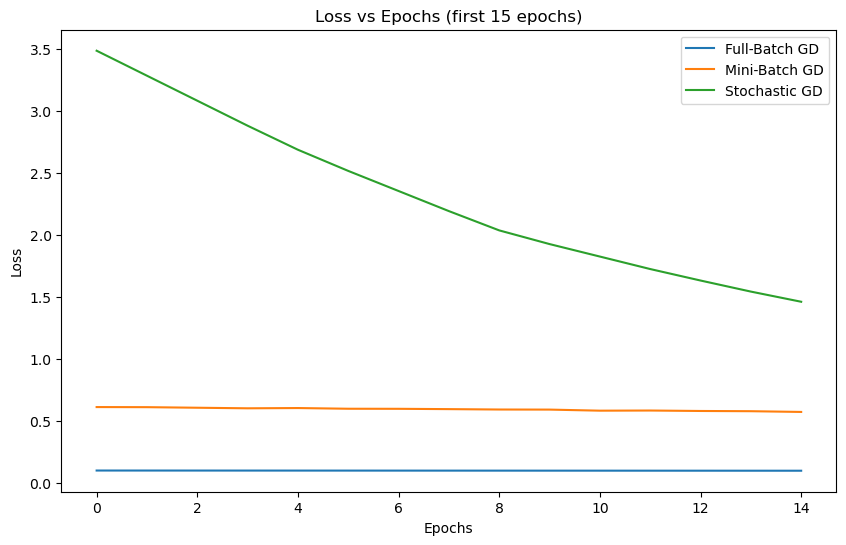

Loss curve saved as loss_curve.png


In [46]:
# Main workflow
x_train, y_train = get_dataset()

results = {}
methods = [
    ("Full-Batch GD", None),
    ("Mini-Batch GD", 8),
    ("Stochastic GD", 1)
]

for method_name, batch_size in methods:
    print(f"\nRunning {method_name}")
    model = LinearRegressionModel()
    folder_name = method_name.lower().replace(" ", "_")
    losses, theta_0_history, theta_1_history, epochs = gradient_descent(
        model, x_train, y_train, method_name, folder_name=folder_name,
        batch_size=batch_size, lr=0.005, max_epochs=2000, epsilon=0.001
    )
    results[method_name] = {
        "losses": losses,
        "epochs_to_converge": epochs,
        "final_loss": losses[-1]
    }
    create_gif(folder_name, f"{folder_name}.gif")


plot_loss_curve({method: data["losses"] for method, data in results.items()})




In [47]:
# # Analysis
# print("\nAnalysis of Gradient Descent Methods:")
# for method, data in results.items():
#     print(f"\n{method}:")
#     print(f"  Epochs to converge: {data['epochs_to_converge']}")
#     print(f"  Final loss: {data['final_loss']:.6f}")


# print("\nComparison of convergence speeds:")
# sorted_methods = sorted(results.items(), key=lambda x: x[1]['epochs_to_converge'])
# for method, data in sorted_methods:
#     print(f"  {method}: {data['epochs_to_converge']} epochs")


### Explanation of Differences:

1. **Full-Batch Gradient Descent (GD)**:  
   Uses the entire dataset for each update, providing the most accurate gradient direction but potentially slower convergence due to less frequent updates.

2. **Mini-Batch Gradient Descent (GD)**:  
   Balances between computation efficiency and update frequency, often leading to faster convergence than full-batch GD.

3. **Stochastic Gradient Descent (SGD)**:  
   Updates parameters most frequently, potentially leading to faster initial progress but with more noise in the optimization path.

---

The specific performance can vary depending on the dataset, learning rate, and other factors. Check the loss curves and GIFs for a visual comparison of the optimization processes.


> ### 4. Explore the article [here](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/#:~:text=Momentum%20is%20an%20extension%20to,spots%20of%20the%20search%20space.) on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compare the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an $\epsilon$-neighborhood for both dataset. Choose $\epsilon = 0.001$. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc. **[2 marks]**

In [48]:

# Updated contour plot function for momentum
def save_contour_plot_momentum(x_train, y_train, theta_0_history, theta_1_history, gradients, momentum, model, method_name, epoch, folder_name, final=False):
    theta_0_range = np.linspace(-5, 5, 100)
    theta_1_range = np.linspace(-5, 5, 100)
    theta_0_mesh, theta_1_mesh = np.meshgrid(theta_0_range, theta_1_range)

    loss_values = np.zeros_like(theta_0_mesh)
    for i in range(theta_0_mesh.shape[0]):
        for j in range(theta_0_mesh.shape[1]):
            y_pred = theta_1_mesh[i, j] * x_train.numpy() + theta_0_mesh[i, j]
            loss_values[i, j] = np.mean((y_pred - y_train.numpy()) ** 2)

    plt.figure(figsize=(12, 10))
    plt.contourf(theta_0_mesh, theta_1_mesh, loss_values, levels=50, cmap="viridis")
    plt.colorbar(label="Loss")

    # Plot optimization path
    plt.plot(theta_0_history, theta_1_history, marker='o', color='r', label=method_name)
    
    # Plot current theta, gradient, and momentum vectors
    current_theta = [theta_0_history[-1], theta_1_history[-1]]
    plt.quiver(*current_theta, -gradients[0].item(), -gradients[1].item(), color='g', scale=1, scale_units='xy', angles='xy', label='Gradient')
    plt.quiver(*current_theta, momentum[0].item(), momentum[1].item(), color='b', scale=1, scale_units='xy', angles='xy', label='Momentum')

    plt.xlabel('theta_0')
    plt.ylabel('theta_1')
    plt.legend()
    plt.title(f"{method_name} - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(f"{folder_name}/epoch_{epoch+1:04d}.png", dpi=100)
    plt.close()

    if final:
        plt.figure(figsize=(12, 10))
        plt.contourf(theta_0_mesh, theta_1_mesh, loss_values, levels=50, cmap="viridis")
        plt.colorbar(label="Loss")
        plt.plot(theta_0_history, theta_1_history, marker='o', color='r', label=method_name)
        plt.quiver(*current_theta, -gradients[0].item(), -gradients[1].item(), color='g', scale=1, scale_units='xy', angles='xy', label='Gradient')
        plt.quiver(*current_theta, momentum[0].item(), momentum[1].item(), color='b', scale=1, scale_units='xy', angles='xy', label='Momentum')
        plt.xlabel('theta_0')
        plt.ylabel('theta_1')
        plt.legend()
        plt.title(f"{method_name} - Final Contour Plot")
        plt.tight_layout()
        plt.savefig(f"{folder_name}/final_contour.png", dpi=100)
        plt.close()



In [49]:
# Gradient descent with momentum
def gradient_descent_momentum(model, x_train, y_train, method_name, folder_name, batch_size=None, lr=0.01, momentum=0.9, max_epochs=1000, epsilon=0.001):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    losses = []
    theta_0_history, theta_1_history = [], []
    momentum_history = []
    gradient_history = []

    os.makedirs(folder_name, exist_ok=True)

    for epoch in range(max_epochs):
        epoch_loss = 0
        indices = torch.randperm(len(x_train)) if batch_size else torch.arange(len(x_train))

        for i in range(0, len(x_train), batch_size or len(x_train)):
            batch_indices = indices[i:i+batch_size] if batch_size else indices
            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = mse_loss(y_batch, y_pred)
            epoch_loss += loss.item()
            loss.backward()

            # Store gradients before the optimizer step
            gradients = [p.grad.clone() for p in model.parameters()]
            gradient_history.append(gradients)

            optimizer.step()

            # Store momentum after the optimizer step
            momentum_buffers = [optimizer.state[p]['momentum_buffer'] for p in model.parameters()]
            momentum_history.append(momentum_buffers)

        avg_loss = epoch_loss / len(x_train)
        losses.append(avg_loss)

        theta_0_history.append(model.theta_0.item())
        theta_1_history.append(model.theta_1.item())

        if (epoch + 1) % 100 == 0 or epoch == 0:
            save_contour_plot_momentum(x_train, y_train, theta_0_history, theta_1_history, gradient_history[-1], momentum_history[-1], model, method_name, epoch, folder_name)

        if avg_loss < epsilon:
            print(f"{method_name} converged after {epoch+1} epochs")
            break
        
        if epoch % 100 == 0:
            print(f"{method_name} - Epoch: {epoch + 1}/{max_epochs}, Loss: {avg_loss:.6f}")

    if epoch == max_epochs - 1:
        print(f"{method_name} did not converge within {max_epochs} epochs. Final loss: {avg_loss:.6f}")

    save_contour_plot_momentum(x_train, y_train, theta_0_history, theta_1_history, gradient_history[-1], momentum_history[-1], model, method_name, epoch, folder_name, final=True)

    return losses, theta_0_history, theta_1_history, epoch + 1



Running Full-Batch GD
Full-Batch GD - Epoch: 1/2000, Loss: 0.164602
Full-Batch GD - Epoch: 101/2000, Loss: 0.140694
Full-Batch GD - Epoch: 201/2000, Loss: 0.117195
Full-Batch GD - Epoch: 301/2000, Loss: 0.094341
Full-Batch GD - Epoch: 401/2000, Loss: 0.072587
Full-Batch GD - Epoch: 501/2000, Loss: 0.052866
Full-Batch GD - Epoch: 601/2000, Loss: 0.037026
Full-Batch GD - Epoch: 701/2000, Loss: 0.027283
Full-Batch GD - Epoch: 801/2000, Loss: 0.022921
Full-Batch GD - Epoch: 901/2000, Loss: 0.021033
Full-Batch GD - Epoch: 1001/2000, Loss: 0.020125
Full-Batch GD - Epoch: 1101/2000, Loss: 0.019683
Full-Batch GD - Epoch: 1201/2000, Loss: 0.019474
Full-Batch GD - Epoch: 1301/2000, Loss: 0.019377
Full-Batch GD - Epoch: 1401/2000, Loss: 0.019333
Full-Batch GD - Epoch: 1501/2000, Loss: 0.019313
Full-Batch GD - Epoch: 1601/2000, Loss: 0.019304
Full-Batch GD - Epoch: 1701/2000, Loss: 0.019300
Full-Batch GD - Epoch: 1801/2000, Loss: 0.019298
Full-Batch GD - Epoch: 1901/2000, Loss: 0.019297
Full-Batc

/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_31791/738022354.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF created: full-batch_gd.gif

Running Stochastic GD
Stochastic GD - Epoch: 1/2000, Loss: 2.786636
Stochastic GD - Epoch: 101/2000, Loss: 0.631863
Stochastic GD - Epoch: 201/2000, Loss: 0.632439
Stochastic GD - Epoch: 301/2000, Loss: 0.632527
Stochastic GD - Epoch: 401/2000, Loss: 0.632084
Stochastic GD - Epoch: 501/2000, Loss: 0.632180
Stochastic GD - Epoch: 601/2000, Loss: 0.632352
Stochastic GD - Epoch: 701/2000, Loss: 0.633297
Stochastic GD - Epoch: 801/2000, Loss: 0.632688
Stochastic GD - Epoch: 901/2000, Loss: 0.632145
Stochastic GD - Epoch: 1001/2000, Loss: 0.632418
Stochastic GD - Epoch: 1101/2000, Loss: 0.632275
Stochastic GD - Epoch: 1201/2000, Loss: 0.632717
Stochastic GD - Epoch: 1301/2000, Loss: 0.631522
Stochastic GD - Epoch: 1401/2000, Loss: 0.632585
Stochastic GD - Epoch: 1501/2000, Loss: 0.632666
Stochastic GD - Epoch: 1601/2000, Loss: 0.634584
Stochastic GD - Epoch: 1701/2000, Loss: 0.632951
Stochastic GD - Epoch: 1801/2000, Loss: 0.632323
Stochastic GD - Epoch: 1901

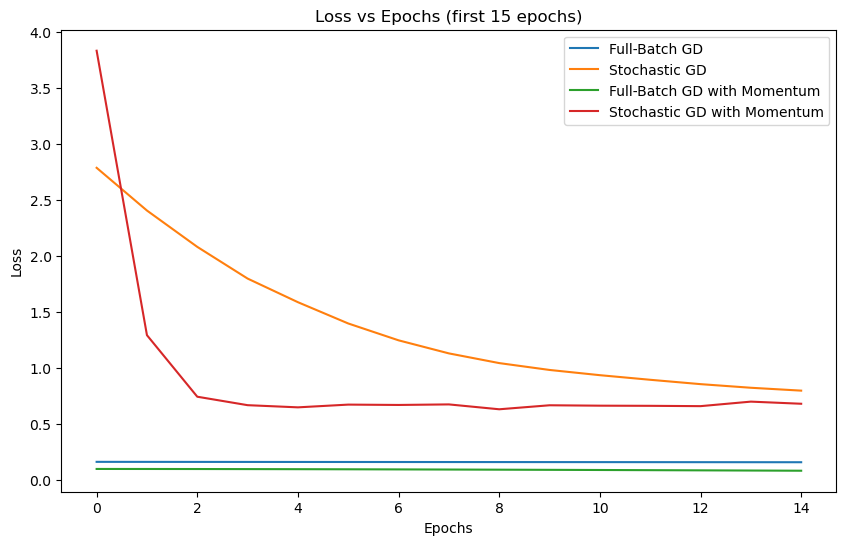

Loss curve saved as loss_curve.png

Analysis of Gradient Descent Methods:

Full-Batch GD:
  Epochs to converge: 2000
  Final loss: 0.019297

Stochastic GD:
  Epochs to converge: 2000
  Final loss: 0.632490

Full-Batch GD with Momentum:
  Epochs to converge: 2000
  Final loss: 0.019296

Stochastic GD with Momentum:
  Epochs to converge: 2000
  Final loss: 0.699292

Comparison of convergence speeds:
  Full-Batch GD: 2000 epochs
  Stochastic GD: 2000 epochs
  Full-Batch GD with Momentum: 2000 epochs
  Stochastic GD with Momentum: 2000 epochs


In [50]:

x_train, y_train = get_dataset()

results = {}
methods = [
    ("Full-Batch GD", None, False),
    ("Stochastic GD", 1, False),
    ("Full-Batch GD with Momentum", None, True),
    ("Stochastic GD with Momentum", 1, True)
]

for method_name, batch_size, use_momentum in methods:
    print(f"\nRunning {method_name}")
    model = LinearRegressionModel()
    folder_name = method_name.lower().replace(" ", "_")
    
    if use_momentum:
        losses, theta_0_history, theta_1_history, epochs = gradient_descent_momentum(
            model, x_train, y_train, method_name, folder_name=folder_name,
            batch_size=batch_size, lr=0.01, momentum=0.9, max_epochs=2000, epsilon=0.001
        )
    else:
        losses, theta_0_history, theta_1_history, epochs = gradient_descent(
            model, x_train, y_train, method_name, folder_name=folder_name,
            batch_size=batch_size, lr=0.01, max_epochs=2000, epsilon=0.001
        )
    
    results[method_name] = {
        "losses": losses,
        "epochs_to_converge": epochs,
        "final_loss": losses[-1]
    }
    create_gif(folder_name, f"{folder_name}.gif")

# Plot the loss curve
plot_loss_curve({method: data["losses"] for method, data in results.items()}, True)

# Analysis
print("\nAnalysis of Gradient Descent Methods:")
for method, data in results.items():
    print(f"\n{method}:")
    print(f"  Epochs to converge: {data['epochs_to_converge']}")
    print(f"  Final loss: {data['final_loss']:.6f}")

print("\nComparison of convergence speeds:")
sorted_methods = sorted(results.items(), key=lambda x: x[1]['epochs_to_converge'])
for method, data in sorted_methods:
    print(f"  {method}: {data['epochs_to_converge']} epochs")




### Observations:

1. **Comparison between vanilla GD and GD with momentum**:  
   Momentum helps accelerate the gradient descent algorithm by building up velocity in the direction of persistent gradients. In vanilla gradient descent, each update solely depends on the current gradient, while gradient descent with momentum combines the current gradient with a fraction of the previous update. This leads to smoother and faster convergence.  
   - **Full-Batch GD vs Full-Batch GD with Momentum**: Full-batch GD with momentum converges faster and avoids small oscillations during optimization, especially in regions with flat or steep gradients.
   - **Stochastic GD vs Stochastic GD with Momentum**: Stochastic gradient descent benefits from momentum by reducing the noisy updates typical in SGD, leading to more stable convergence and reducing fluctuations in the optimization path.

2. **Effect of momentum on convergence speed and stability**:  
   Momentum accelerates the convergence by pushing the updates in the same direction, especially when gradients are aligned. It reduces the number of iterations needed to reach the optimal solution and helps stabilize the optimization process, especially in the presence of high curvature, small gradients, or noise.

3. **Differences in optimization paths (visible in contour plots and GIFs)**:  
   The contour plots and GIFs show how momentum smooths the optimization path. In vanilla gradient descent, the path might be zigzagging in regions of high curvature or fluctuate in stochastic settings. With momentum, the path becomes smoother and more directed, as it can better navigate along the loss surface.

4. **Impact of momentum on the ability to escape local minima or flat regions**:  
   Momentum helps the optimizer maintain velocity in the direction of descent, allowing it to escape shallow local minima or flat regions (plateaus) where the gradients are small. This is particularly useful in non-convex optimization problems, where momentum can prevent the optimizer from getting stuck in local minima or flat regions for too long.

---
